## Analiza danych

#### Przegląd atrybutów

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import ast

listings = pd.read_csv("../data/raw/listings.csv")
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1458 non-null   int64  
 1   listing_url                                   1458 non-null   object 
 2   scrape_id                                     1458 non-null   int64  
 3   last_scraped                                  1458 non-null   object 
 4   source                                        1458 non-null   object 
 5   name                                          1458 non-null   object 
 6   description                                   1433 non-null   object 
 7   neighborhood_overview                         726 non-null    object 
 8   picture_url                                   1458 non-null   object 
 9   host_id                                       1458 non-null   i

#### Wybór atrybutów 
Do obliczenia przewidywanej ceny wymagane są przede wszystkim kolumny definiujące standard kwatery. 
Atrybuty związane z dostępnością, cechami gospodarza lub opiniami użytkowników mogą także mieć wpływ na zmienną objaśnianą, dlatego póki co nie zostają usunięte (jeśli późniejsza analiza wskaże, że są wtórne zostaną wykluczone). Dodatkowo można pozbyć się kolumn zawierających metadane, ponieważ są one całkowicie nieinformatywne.

Lista wybranych początkowo atrybutów znajduje się w pliku *features.py*, a zastosowanych transformacji w *transformations/listings.py*.

In [ ]:
from src.features import INITIAL_FEATURES, TARGET
from src.transformations.listings import *

listings = select_features(listings, INITIAL_FEATURES, TARGET)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           1458 non-null   object 
 1   room_type               1458 non-null   object 
 2   accommodates            1458 non-null   int64  
 3   bathrooms               1369 non-null   float64
 4   bathrooms_text          1456 non-null   object 
 5   bedrooms                1446 non-null   float64
 6   beds                    1370 non-null   float64
 7   amenities               1458 non-null   object 
 8   description             1433 non-null   object 
 9   neighborhood_overview   726 non-null    object 
 10  latitude                1458 non-null   float64
 11  longitude               1458 non-null   float64
 12  host_response_time      1276 non-null   object 
 13  host_response_rate      1276 non-null   object 
 14  host_acceptance_rate    1370 non-null   

#### Atrybuty nienumeryczne

In [ ]:
object_columns = listings.select_dtypes(include=["object"]).columns
for col in object_columns:
    print(f"{col}: {listings[col][0]}")

property_type: Entire condo
room_type: Entire home/apt
bathrooms_text: 1 bath
amenities: ["Host greets you", "Coffee maker: Keurig coffee machine", "Coffee", "Outlet covers", "Dishes and silverware", "Smoking allowed", "Cleaning products", "Shower gel", "Central air conditioning", "Clothing storage: wardrobe and dresser", "Hair dryer", "Refrigerator", "Essentials", "Heating", "Dedicated workspace", "Safe", "Cooking basics", "Drying rack for clothing", "Hangers", "Freezer", "Karavaki body soap", "Crib", "Hot water", "Books and reading material", "Oven", "Stove", "Blender", "Baking sheet", "Microwave", "Long term stays allowed", "Iron", "Room-darkening shades", "Bed linens", "Shampoo", "Free washer \u2013 In unit", "Dishwasher", "Smoke alarm", "Hot water kettle", "Wine glasses", "First aid kit", "Dining table", "Extra pillows and blankets", "Private patio or balcony", "Free street parking", "Kitchen", "Pack \u2019n play/Travel crib", "Carbon monoxide alarm", "Children\u2019s dinnerware",

#### *property_type* i *room_type*

In [ ]:
listings["property_type"].isna().sum()

np.int64(0)

In [ ]:
listings["property_type"].value_counts()

property_type
Entire rental unit                    948
Entire condo                          300
Private room in rental unit            39
Entire home                            32
Entire serviced apartment              32
Room in aparthotel                     20
Room in hotel                          19
Entire loft                            11
Private room in condo                  10
Room in boutique hotel                  7
Room in serviced apartment              6
Private room in home                    5
Private room in serviced apartment      4
Entire villa                            4
Private room in guest suite             4
Private room in guesthouse              3
Entire townhouse                        3
Entire guesthouse                       2
Shared room in hostel                   2
Tiny home                               1
Private room in hostel                  1
Entire guest suite                      1
Camper/RV                               1
Shared room in condo

W celu ograniczenia szumu wynikającego z wielu wartości w kolumnie property type, wartości zostały zgeneralizowane do kilku podstawowych kategorii. Pondato został dodany nowy atrybut (*is_luxury*), który wskazuje czy dane lokum jest luksusowe. Taki atrybut może być silnie skorelowany z ceną.

In [ ]:
listings = add_is_luxury_attribute(listings)
listings["is_luxury"].value_counts()

is_luxury
0    1436
1      22
Name: count, dtype: Int64

<Axes: ylabel='count'>

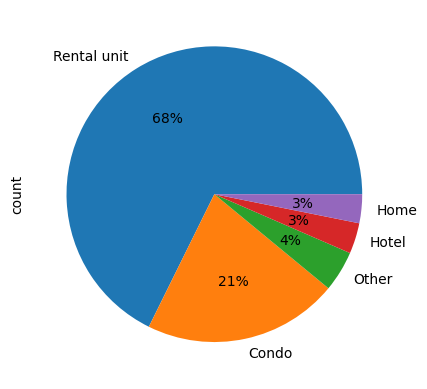

In [ ]:
listings = aggregate_property_type(listings)
listings["property_type"].value_counts().plot(kind="pie", autopct="%1.0f%%")

Atrybut *room_type* pozostaje bez zmian, jest już wystarczająco dobrze podzielony na podgrupy. 

In [ ]:
listings["room_type"].isna().sum()

np.int64(0)

In [ ]:
listings["room_type"].value_counts()

room_type
Entire home/apt    1347
Private room         95
Hotel room           13
Shared room           3
Name: count, dtype: int64

#### *bathrooms_text* i *bathrooms*

Puste wartości w *bathrooms* zostały uzupełnione biorąc dane z *bathrooms_text* - tam braków jest zdecydowanie mniej. Ponadto dodano nowy atrybut *is_bathroom_shared*, który został wyłuskany z tekstu. Po przetworzeniu danych w *bathroom_text* ten atrybut może zostać całkowicie usunięty, nie niesie żadnej nowej informacji.

In [ ]:
print(listings["bathrooms_text"].isna().sum())
print(listings["bathrooms"].isna().sum())

2
89


In [ ]:
listings = fill_bathrooms_values_from_text(listings)
print(listings["bathrooms_text"].isna().sum())
print(listings["bathrooms"].isna().sum())

2
1


In [ ]:
listings = add_is_bathroom_shared_attribute(listings)
listings["is_bathroom_shared"].value_counts()

is_bathroom_shared
0    1411
1      45
Name: count, dtype: Int64

#### *amenities*

In [ ]:
listings["amenities"].isna().sum()

np.int64(0)

In [ ]:
listings["amenities"].head(10)

0    ["Host greets you", "Coffee maker: Keurig coff...
1    ["Luggage dropoff allowed", "Dishes and silver...
2    ["Host greets you", "Coffee", "Dishes and silv...
3    ["Coffee", "Dishes and silverware", "Cleaning ...
4    ["Host greets you", "Coffee", "Dishes and silv...
5    ["Host greets you", "Coffee", "Dishes and silv...
6    ["Dishes and silverware", "Hair dryer", "Refri...
7    ["Dishes and silverware", "Toaster", "Exercise...
8    ["Host greets you", "Dishes and silverware", "...
9    ["Coffee maker: drip coffee maker, espresso ma...
Name: amenities, dtype: object

In [ ]:
from src.amenities_correlation import get_amenities_counter

counter = get_amenities_counter(listings)
unique = [a for a, _ in counter.items()]
print(f'Unique amenities: {len(unique)}')

Unique amenities: 882


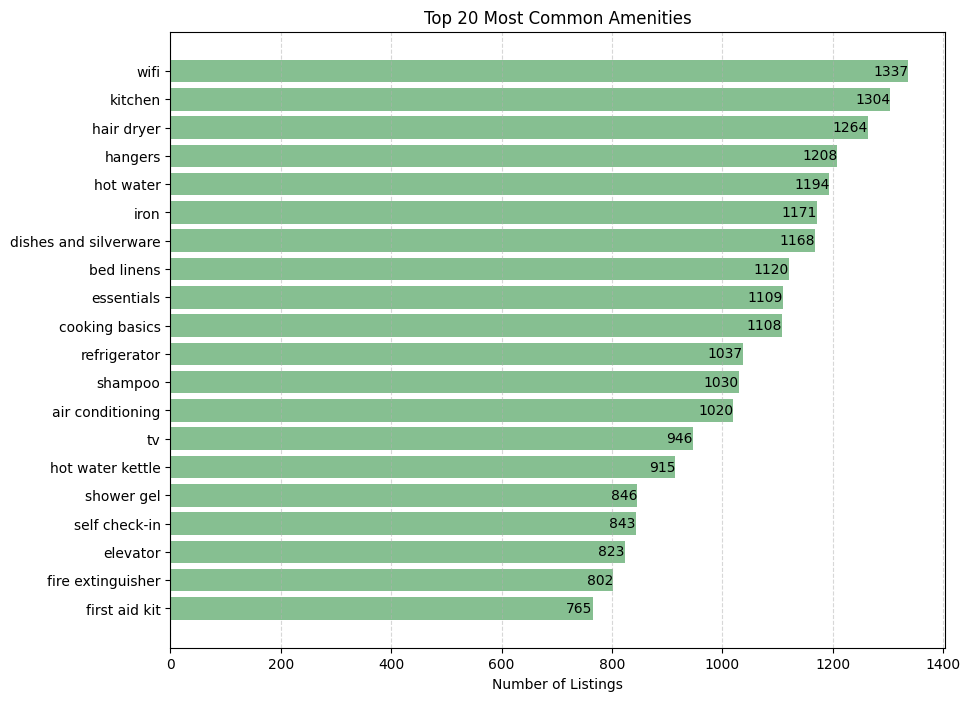

In [ ]:
top_20 = counter.most_common(20)
amenities, counts = zip(*top_20)

plt.figure(figsize=(10,8))
bars = plt.barh(amenities[::-1], counts[::-1], color="#86bf91")
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width, y, str(width),  va="center", ha="right")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.xlabel("Number of Listings")
plt.title("Top 20 Most Common Amenities")
plt.show()

Z uwagi na bardzo dużą liczbę unikalnych udogodnień zostanie wybranych 10, które:
- wyglądają wymiernie (ocena subiektywna);
- mają dużą korelację Spearmana z kolumną price;
- występują w minimum 50 obiektach.

In [ ]:
from src.amenities_correlation import calc_amenities_correlation, calc_amenities_mutual_info

amenities_correlation_df = calc_amenities_correlation(listings.copy(), min_freq=50)
amenities_mutual_info_df = calc_amenities_mutual_info(listings.copy(), min_freq=50)["mutual_info"]

merged = (
    amenities_correlation_df.rename("spearman")
    .to_frame()
    .join(amenities_mutual_info_df.rename("mutual_info"), how="inner")
    .sort_values("spearman", ascending=False)
)

merged.head(n=15)

,spearman,mutual_info
dishwasher,0.213018,0.045614
iron,0.173163,0.021600
high chair,0.172236,0.020410
toaster,0.169160,0.012228
oven,0.165238,0.040578
kitchen,0.156842,0.023109
microwave,0.150322,0.018097
crib,0.146960,0.014010
dining table,0.146696,0.023611
free dryer – in unit,0.144451,0.015457


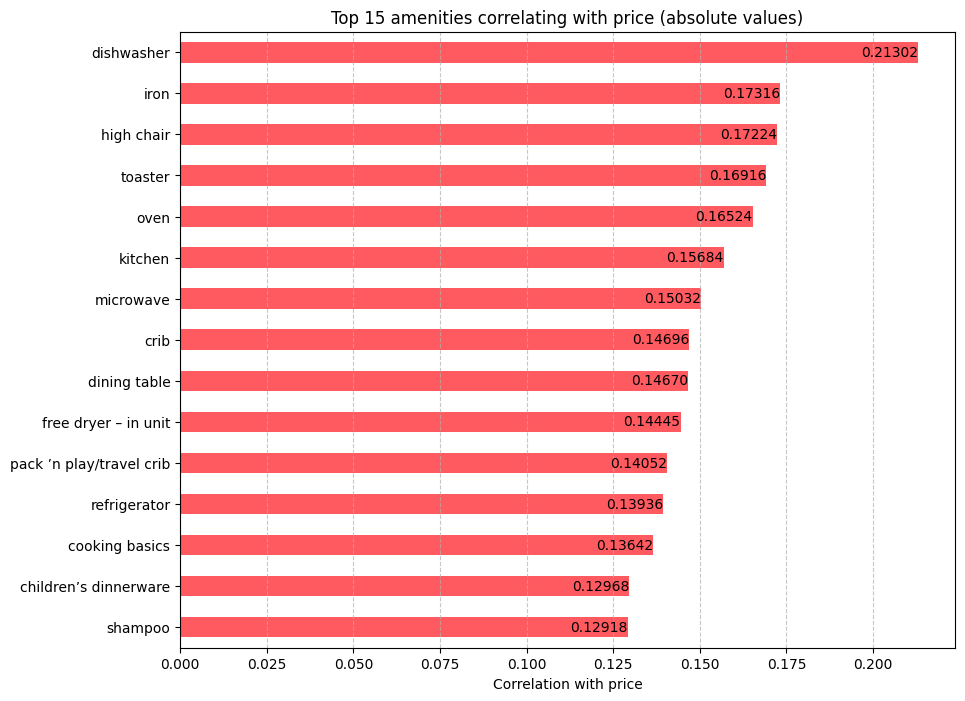

In [ ]:
amenities_correlation_df = amenities_correlation_df.abs()

top_15 = amenities_correlation_df.sort_values(ascending=False).head(15)
ax = top_15.sort_values(ascending=True).plot(
    kind='barh',
    figsize=(10, 8),
    color='#FF5A5F',
    title='Top 15 amenities correlating with price (absolute values)'
)
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width, y, f"{width:.5f}",  va="center", ha="right")
plt.xlabel('Correlation with price')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Finalnie wybrane udogodnienia to:

In [ ]:
from src.features import AMENITIES
AMENITIES

['dishwasher',
 'iron',
 'toaster',
 'oven',
 'kitchen',
 'microwave',
 'crib',
 'dining table',
 'Free dryer – In unit',
 'Pack ’n play/Travel crib']

Zostaną one zakodowane binarnie

In [ ]:
listings = encode_amenities_binary(listings, AMENITIES)
filtered = listings.filter(like="amenity")
filtered.info()

,amenity_dishwasher,amenity_iron,amenity_toaster,amenity_oven,amenity_kitchen,amenity_microwave,amenity_crib,amenity_dining_table,amenity_free_dryer_–_in_unit,amenity_pack_’n_play_travel_crib
0,1,1,0,1,1,1,1,1,0,1
1,1,1,0,1,1,0,1,0,0,1
2,1,1,1,1,1,0,0,1,0,0
3,0,1,1,0,1,1,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0


#### *description* i *neighborhood_overview*
W przypadku kolumn zawierających opisy tekstowe zostanie wyznaczonych ich sentyment. Często opisy zawierają kluczowe informacje dotyczące standardu mieszkania czy też atrakcyjności okolicy, których nie da się uwzględnić w innych atrybutach. Przed wyliczaniem atrybutu dane tekstowe są czyszczone z tagów html. Wartości puste zostaną później uzupełnione w pipelinie ml. 

In [ ]:
listings["description"].isna().sum()

np.int64(25)

In [ ]:
listings["description"].head()

0    PANORMOU METRO STASION<br /><br />5 minut from...
1                                                  NaN
2    One bedroom apt with large windows overlooking...
3    Ground Floor 50sqm Vintage Style Apartment w/e...
4    This colorful, spacious and clean apt is locat...
Name: description, dtype: object

In [ ]:
listings = convert_description_to_sentiment(listings)
listings["description_sentiment"].describe()

count    1433.000000
mean        0.262052
std         0.153357
min        -0.300000
25%         0.160130
50%         0.262500
75%         0.360714
max         0.905556
Name: description_sentiment, dtype: float64

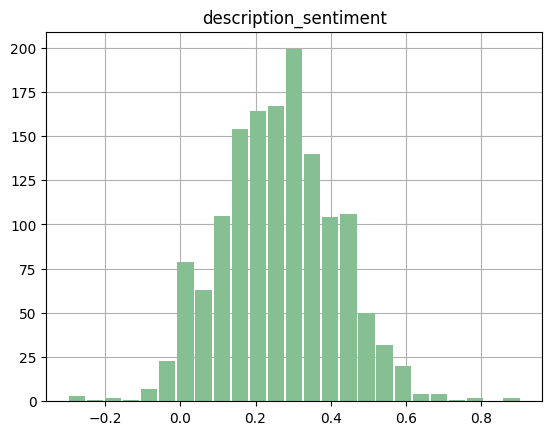

In [ ]:
hist = listings.hist(bins=25, column="description_sentiment", color="#86bf91", zorder=2, rwidth=0.9)

In [ ]:
listings["neighborhood_overview"].isna().sum()

np.int64(732)

In [ ]:
listings = convert_neighborhood_overview_to_setiment(listings)
listings["neighborhood_overview_sentiment"].describe()

count    726.000000
mean       0.206580
std        0.126698
min       -0.250000
25%        0.133996
50%        0.205239
75%        0.278713
max        0.708333
Name: neighborhood_overview_sentiment, dtype: float64

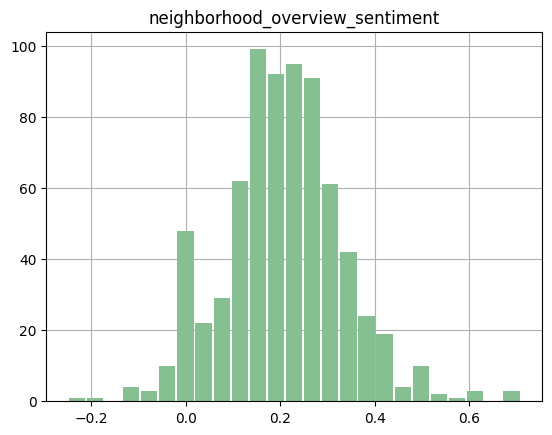

In [ ]:
hist = listings.hist(bins=25, column="neighborhood_overview_sentiment", color="#86bf91", zorder=2, rwidth=0.9)

Rozkłady sentymentów okazały się zaskakujące. Wbrew wstępnym założeniom, zgodnie z którymi wystawiający oferty powinni wykazywać tendencję do nadmiernie pozytywnego opisywania swoich lokali, analizowany atrybut charakteryzuje się rozkładem zbliżonym do neutralnego.

#### *host_response_time*
W przypadku tego atrybutu można dostrzec, że ma on natrualny porządek tzn. *within an hour* jest większe/lepsze niż *within a few hours* - na etapie pipelinu ml można stosować kodowanie polegające na przypisaniu kolejnych liczb całkowitych.

In [ ]:
listings["host_response_time"].isna().sum()

np.int64(182)

<Axes: ylabel='count'>

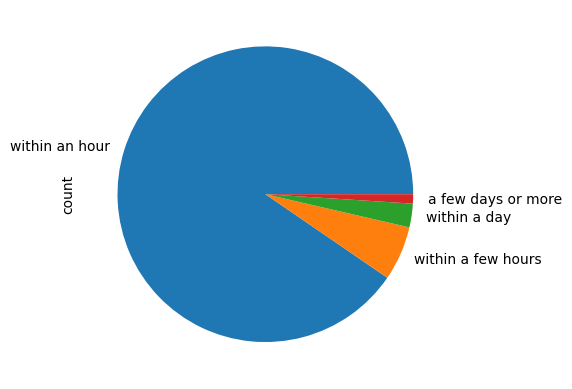

In [ ]:
listings["host_response_time"].value_counts().plot(kind="pie")

#### *host_response_rate* i *host_acceptance_rate*
Te atrybuty wymagają zamienienia łańcuchów znaków reperezentujących procenty na liczby zmiennoprzecinkowe.

In [ ]:
listings["host_response_rate"].head()

0    100%
1    100%
2    100%
3    100%
4     NaN
Name: host_response_rate, dtype: object

In [ ]:
columns_to_convert = ["host_response_rate", "host_acceptance_rate"]
listings = convert_percentage_columns(listings, columns_to_convert)

for col in columns_to_convert:
    print(f"{col} example value: {listings[col][0]}")


host_response_rate example value: 1.0
host_acceptance_rate example value: 1.0


#### *host_is_superhost*, *host_identity_verifed* i *instant_bookable*
Powyższe atrybuty zamiast wartości binarnych są reprezentowane przez *"t" i "f"* - muszą zostać zamienione na wartości liczbowe, żeby model był w stanie je obsłużyć.

In [ ]:
listings["host_is_superhost"].head()

0    f
1    t
2    t
3    f
4    f
Name: host_is_superhost, dtype: object

In [ ]:
columns_to_convert = ["host_is_superhost", "host_identity_verified", "instant_bookable"]
listings = convert_tf_columns(listings, columns_to_convert)

for col in columns_to_convert:
    print(f"{col} example value: {listings[col][0]}")

host_is_superhost example value: 0
host_identity_verified example value: 1
instant_bookable example value: 0


### Target - *price*

In [ ]:
listings["price"].isna().sum()

np.int64(0)

In [ ]:
listings["price"].head()

0     $80.00
1    $250.00
2    $175.00
3    $190.00
4    $210.00
Name: price, dtype: object

In [ ]:
listings = convert_price_to_number(listings)
listings["price"].head()

0     80.0
1    250.0
2    175.0
3    190.0
4    210.0
Name: price, dtype: float64

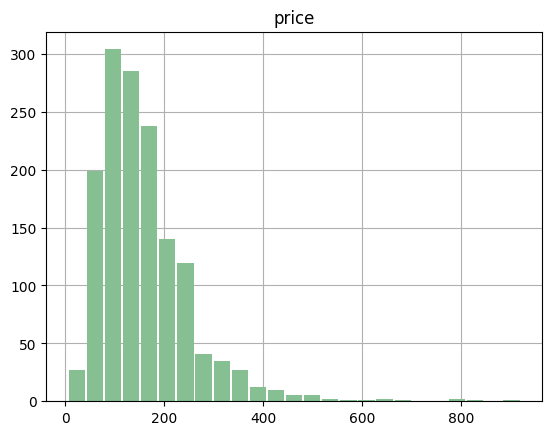

In [ ]:
hist = listings.hist(bins=25, column="price", color="#86bf91", zorder=2, rwidth=0.9)

W celu minimalizacji znaczenia outlinerów (ceny mocno odbiegające od średniej) zastosowano skalowanie logarytmiczne, które ustabilizuje proces uczenia.

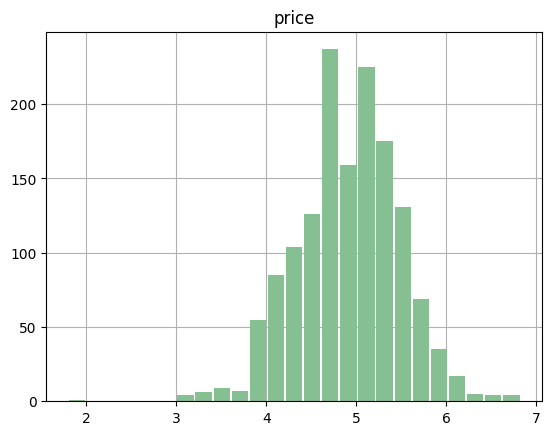

In [ ]:
listings = transform_price(listings)
hist = listings.hist(bins=25, column="price", color="#86bf91", zorder=2, rwidth=0.9)

In [ ]:
listings["price"].describe()

count    1458.000000
mean        4.910746
std         0.565203
min         1.791759
25%         4.564348
50%         4.948760
75%         5.278115
max         6.825460
Name: price, dtype: float64